In [1]:
!pip install -q gym

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import gym
from gym.envs.registration import register
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
register(
    id='Deterministic-4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False})
register(
    id='ShorterChain-v0',
    entry_point='gym.envs.toy_text:NChainEnv',
    timestep_limit=100
)

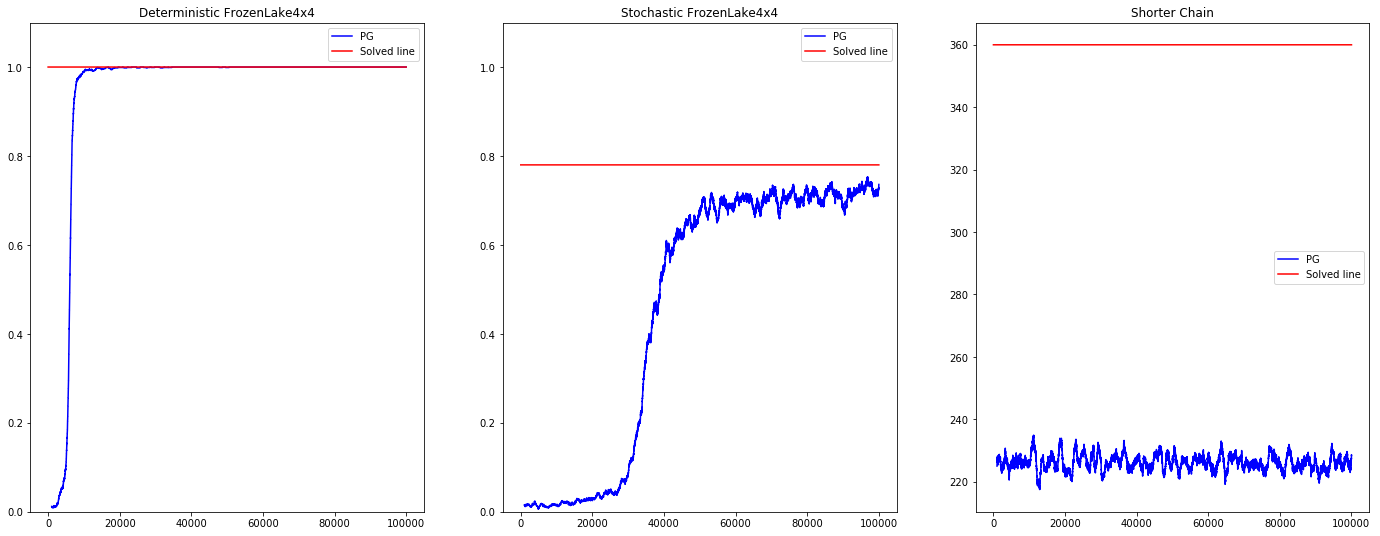

In [4]:
envs = []
envs.append(gym.make('Deterministic-4x4-FrozenLake-v0'))
envs.append(gym.make('FrozenLake-v0'))
envs.append(gym.make('ShorterChain-v0'))

num_episodes = 100000
num_experiments = len(envs)

episodic_reward = np.zeros((num_experiments, num_episodes))
alpha = 0.01

window_size = 1000

for j in range(num_experiments):
  
  env = envs[j]
  num_states = env.observation_space.n
  num_actions = env.action_space.n
  weights = np.ones((num_states, num_actions))
  
  for i in range(num_episodes):
  
    obs = env.reset()
    cum_reward = 0
    transitions = []

    while(True):
      p = np.exp(weights[obs]-np.max(weights))/np.sum(np.exp(weights[obs]-np.max(weights)))
      action = np.random.choice(range(num_actions), p=p)
      nextObs, reward, done, info = env.step(action)
      cum_reward += reward
      transitions.append((obs, action, reward, nextObs))
      obs = nextObs
      if done:
        remaining_reward = cum_reward
        episodic_reward[j][i] = cum_reward
        for t in transitions:
          s, a, r, s_ = t
          score = 1 - np.exp(weights[s][a])/np.sum(np.exp(weights[s]))
          dTheta = alpha * score * remaining_reward
          remaining_reward -= r
          weights[s][a] += dTheta
        break
        
plt.rcParams["figure.figsize"] = (24,9)
plt.figure()
plt.subplot(1,3,1)
MA = pd.Series(episodic_reward[0]).rolling(window=window_size).mean()
solved_line = np.ones(len(MA)) * 1.0
plt.plot(range(len(MA)), MA, label="PG", color='blue')
plt.plot(range(len(MA)), solved_line, label='Solved line', color='red')
plt.title("Deterministic FrozenLake4x4")
plt.legend(loc='best')    
plt.ylim((0., 1.1))
plt.subplot(1,3,2)
MA = pd.Series(episodic_reward[1]).rolling(window=window_size).mean()
solved_line = np.ones(len(MA)) * 0.78
plt.plot(range(len(MA)), MA, label="PG", color='blue')
plt.plot(range(len(MA)), solved_line, label='Solved line', color='red')
plt.title("Stochastic FrozenLake4x4")
plt.legend(loc='best')
plt.ylim((0., 1.1))
plt.subplot(1,3,3)
MA = pd.Series(episodic_reward[2]).rolling(window=window_size).mean()
solved_line = np.ones(len(MA)) * 360
plt.plot(range(len(MA)), MA, label="PG", color='blue')
plt.plot(range(len(MA)), solved_line, label='Solved line', color='red')
plt.title("Shorter Chain")
plt.legend(loc='best') 
plt.show()
